In [30]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string, re
import urllib
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from nltk.corpus import stopwords


In [2]:
data = pd.read_csv('../Data/2018/listings42018sum.csv')

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,"Casa Madrona - Urban Oasis, 1 block from the P...",2536,Megan,Central Area,Madrona,47.610819,-122.290816,Entire home/apt,296,4,15,2018-04-04,0.13,1,283
1,4291,Sunrise in Seattle Master Suite,35749,Jess & Joey,Other neighborhoods,Roosevelt,47.687801,-122.313427,Private room,82,2,54,2017-08-27,0.93,5,280
2,5682,"Cozy Studio, min. to downtown -WiFi",8993,Maddy,Delridge,South Delridge,47.523980,-122.359891,Entire home/apt,48,3,423,2018-03-29,4.30,1,157
3,6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,Wallingford,47.654109,-122.337605,Entire home/apt,90,2,109,2017-12-07,1.02,3,324
4,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.550620,-122.320135,Private room,65,2,118,2018-02-08,1.26,5,357


In [4]:
data['availability_365'].value_counts

<bound method IndexOpsMixin.value_counts of 0       283
1       280
2       157
3       324
4       357
       ... 
7907     67
7908     58
7909     32
7910    365
7911     72
Name: availability_365, Length: 7912, dtype: int64>

In [5]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [6]:
ohe = OneHotEncoder(sparse=False)
neigh_group = ohe.fit_transform(data[['neighbourhood_group']])
neigh_group_cat = ohe.categories_
neigh = ohe.fit_transform(data[['neighbourhood']])
neigh_cat = ohe.categories_
room = ohe.fit_transform(data[['room_type']])
room_cat = ohe.categories_

In [7]:
def rename(name_of_columns,pre_addition):
    new_list = []
    for x in name_of_columns:
        for x in x:
            new_list.append(pre_addition+ '' + x)
    return new_list

In [8]:
new_neigh_group_cat = rename(neigh_group_cat,'neighbourhood_group: ')
new_neigh_cat = rename(neigh_cat,'neighbourhood: ')
new_room_cat = rename(room_cat,'room_type: ')

In [9]:
# Create categories for neighborhood_group, neighborhood and room_type
neigh_group_df = pd.DataFrame(data=neigh_group,columns=new_neigh_group_cat)
neigh_df = pd.DataFrame(data=neigh,columns=new_neigh_cat)
room_type_df = pd.DataFrame(data=room,columns = new_room_cat);

In [10]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
vectorizer = TfidfVectorizer(strip_accents='unicode',stop_words=stopwords_list,min_df=10, ngram_range=(1,3))

In [11]:
# get rid of na in name column
data.fillna({'name':''}, inplace=True)

In [12]:
tf_idf = vectorizer.fit_transform(data['name'])

In [13]:
nlp_name = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())

In [14]:
clean_data = data.drop(columns = ['id','host_name','host_id','last_review','name','neighbourhood_group','neighbourhood','room_type'])

In [15]:
clean_data['longitude'] = clean_data['longitude'].round(decimals=5)
clean_data['latitude'] = clean_data['latitude'].round(decimals=5)

In [16]:
clean_data = pd.concat([clean_data,neigh_group_df,neigh_df,room_type_df,nlp_name],axis=1)

In [17]:
clean_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group: Ballard,neighbourhood_group: Beacon Hill,...,wheel,wheel condos,whole,wifi,woodland,world,ws,yacht,yard,zen
0,47.61082,-122.29082,296,4,15,0.13,1,283,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,47.68780,-122.31343,82,2,54,0.93,5,280,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,47.52398,-122.35989,48,3,423,4.30,1,157,0.0,0.0,...,0.0,0.0,0.0,0.459669,0.0,0.0,0.0,0.0,0.0,0.0
3,47.65411,-122.33761,90,2,109,1.02,3,324,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,47.55062,-122.32014,65,2,118,1.26,5,357,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
clean_data = clean_data[clean_data.price<800]

In [58]:
X = clean_data.drop(columns = ['price'])
y = clean_data['price']

In [59]:
ss = StandardScaler()
X_ss = ss.fit_transform(X)

In [60]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X_ss,y)

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
lr = LinearRegression()
lr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
lr.score(Xtrain,ytrain)

0.5521889036581231

In [64]:
lr.score(Xtest,ytest)

-3.237565388352e+25

In [68]:
list(zip(lr.coef_,X.columns));

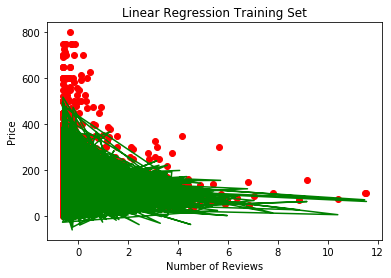

In [71]:
plt.scatter(Xtrain[:,3], ytrain, color = "red")
plt.plot(Xtrain[:,3], lr.predict(Xtrain), color = "green")
plt.title("Linear Regression Training Set")
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.show()

In [146]:
rfr = RandomForestRegressor(n_estimators=1000,min_samples_split=5,min_samples_leaf=3,random_state=42)

In [147]:
# n_estimators=100,min_samples_split=5,min_samples_leaf=4,random_state=42

In [162]:
rfr.fit(Xtrain,ytrain)
rfr.score(Xtrain,ytrain)

0.8748431135114858

In [163]:
ypredtrain = rfr.predict(Xtrain)
ypredtest = rfr.predict(Xtest)

In [164]:
from sklearn.metrics import r2_score
print(r2_score(ytrain,ypredtrain))
print(r2_score(ytest,ypredtest))

0.8748431135114858
0.5613390385852068


In [165]:
print(r2_score(np.exp(ytest),np.exp(ypredtest)))

0.42746388901790633


In [117]:
rfr_param_grid = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['mse'],
    'max_depth': [None, 10, 25, 50,100],
    'min_samples_split': [2,5, 10],
    'min_samples_leaf': [3,6]
}

In [118]:
rf_grid = GridSearchCV(rfr,rfr_param_grid,cv=3)

In [119]:
rf_grid.fit(Xtrain,ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['mse'],
         

In [120]:
rf_grid.best_params_

{'criterion': 'mse',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [170]:
sorted(list(zip(rfr.feature_importances_,clean_data.columns)),reverse=True)[0:10]

[(0.36715884632433937, 'neighbourhood: Yesler Terrace'),
 (0.10866435847643781, 'number_of_reviews'),
 (0.07387682985992262, 'latitude'),
 (0.0476040721898938, 'calculated_host_listings_count'),
 (0.044641426089363966, 'longitude'),
 (0.0430844958172969, 'reviews_per_month'),
 (0.0320137929488898, 'minimum_nights'),
 (0.019772566022663182, 'price'),
 (0.016883374132558658, 'historic'),
 (0.01436684114078817, 'street commons capitol')]

In [173]:
list(zip(np.exp(ytest),np.exp(ypredtest)))[0:10]

[(81.00000000000003, 93.35022932153883),
 (279.9999999999999, 236.30166603580562),
 (85.99999999999997, 92.72939063656055),
 (100.00000000000004, 76.9343962934235),
 (34.00000000000001, 75.57702579742207),
 (49.99999999999999, 68.91971856081707),
 (101.00000000000003, 130.05261550289742),
 (100.00000000000004, 100.86264919423593),
 (90.0, 95.38369940503918),
 (126.99999999999999, 171.60208899169785)]

In [ ]:
# pc = PCA()

In [ ]:
# pc.fit(nlp_name)

In [ ]:
# pc.components_

In [ ]:
# sorted(list(zip(pc.singular_values_,nlp_name.columns)),reverse=True);

In [ ]:
# rfr.fit(nlp_name,y)

In [ ]:
# rfr.score(nlp_name,y)

In [ ]:
# sorted(list(zip(rfr.feature_importances_,nlp_name.columns)),reverse=True)

In [73]:
import seaborn as sbn
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

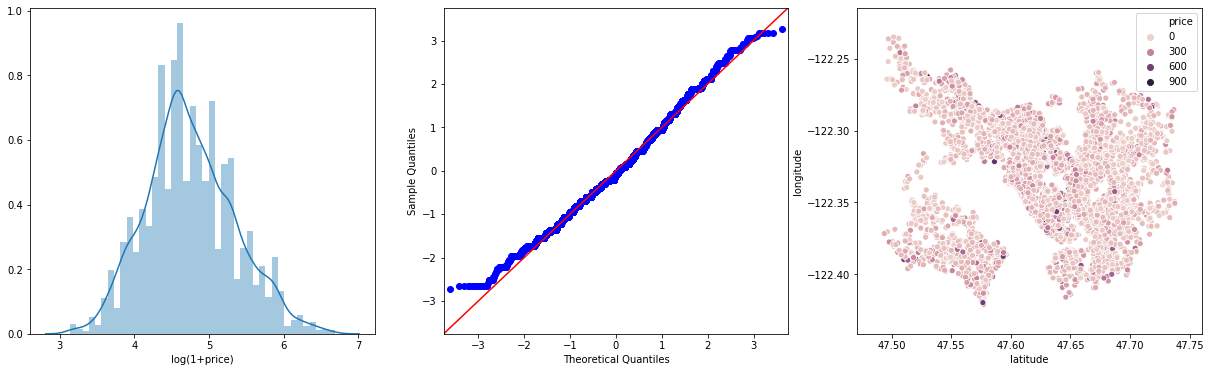

In [156]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sbn.distplot(np.log1p(clean_data['price']), ax=axes[0])
axes[0].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(clean_data['price']), stats.norm, fit=True, line='45', ax=axes[1])
sbn.scatterplot(x= clean_data['latitude'], y=clean_data['longitude'],hue=clean_data['price'],ax=axes[2]);


In [88]:
clean_data = clean_data[clean_data.price>20]
clean_data = clean_data[clean_data.price<800]

In [154]:
clean_data['price']

0       296
1        82
2        48
3        90
4        65
       ... 
7854     60
7863     50
7874     50
7875     90
7882     39
Name: price, Length: 6607, dtype: int64

In [158]:
clean_data['log_price'] = np.log1p(clean_data['price'])

In [135]:
clean_data = clean_data[clean_data.minimum_nights<21]

In [139]:
clean_data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group: Ballard,neighbourhood_group: Beacon Hill,...,wheel,wheel condos,whole,wifi,woodland,world,ws,yacht,yard,zen
count,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,...,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000,6607.000000
mean,47.626696,-122.333747,137.438626,2.062964,42.794763,2.250254,17.898441,133.489178,0.059331,0.036931,...,0.000135,0.000062,0.000991,0.001331,0.000644,0.000924,0.001122,0.001193,0.001077,0.001329
std,0.046170,0.032042,95.352085,1.523050,59.404836,4.029079,60.514820,121.736812,0.236261,0.188606,...,0.007783,0.004999,0.023568,0.025419,0.020132,0.025352,0.020546,0.028717,0.024544,0.028419
min,47.493850,-122.420920,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.605810,-122.354640,75.000000,1.000000,5.000000,0.560000,1.000000,16.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.622140,-122.331080,109.000000,2.000000,19.000000,1.480000,1.000000,98.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.662630,-122.311885,169.000000,2.000000,56.000000,3.310000,4.000000,250.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,47.737550,-122.234870,799.000000,20.000000,690.000000,279.090000,366.000000,365.000000,1.000000,1.000000,...,0.488772,0.406366,0.732896,0.764791,0.777019,0.805792,0.511510,1.000000,0.702758,0.904485


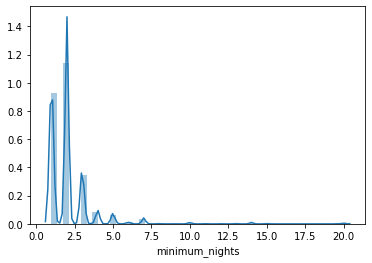

In [137]:
sbn.distplot(clean_data['minimum_nights'])

In [138]:
clean_data = clean_data[clean_data.number_of_reviews>0]

In [140]:
clean_data

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group: Ballard,neighbourhood_group: Beacon Hill,...,wheel,wheel condos,whole,wifi,woodland,world,ws,yacht,yard,zen
0,47.61082,-122.29082,296,4,15,0.13,1,283,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,47.68780,-122.31343,82,2,54,0.93,5,280,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,47.52398,-122.35989,48,3,423,4.30,1,157,0.0,0.0,...,0.0,0.0,0.0,0.459669,0.0,0.0,0.0,0.0,0.0,0.0
3,47.65411,-122.33761,90,2,109,1.02,3,324,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,47.55062,-122.32014,65,2,118,1.26,5,357,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7854,47.68982,-122.35288,60,1,1,1.00,2,303,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7863,47.71757,-122.29553,50,1,1,1.00,1,55,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7874,47.70122,-122.33676,50,1,1,1.00,2,73,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7875,47.62465,-122.35903,90,2,1,1.00,1,12,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
list(zip(ytest,ypredtest));

In [176]:
room_type_df.sum()

room_type: Entire home/apt    5763.0
room_type: Private room       1993.0
room_type: Shared room         156.0
dtype: float64

In [178]:
clean_data[clean_data['room_type: Shared room']==1]

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group: Ballard,neighbourhood_group: Beacon Hill,...,wheel condos,whole,wifi,woodland,world,ws,yacht,yard,zen,log_price
397,47.62529,-122.31942,55,4,11,0.20,58,320,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.025352
399,47.62409,-122.31970,55,4,16,0.29,58,233,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.025352
400,47.62430,-122.31915,55,4,5,0.11,58,279,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.025352
401,47.62513,-122.32051,55,4,15,0.27,58,338,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.025352
402,47.62506,-122.31905,65,4,8,0.15,58,283,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.189655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,47.52829,-122.27830,30,1,6,1.13,3,314,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.433987
6750,47.60626,-122.32162,45,1,5,1.26,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.828641
7326,47.61782,-122.32310,34,1,16,6.08,1,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.555348
7564,47.63103,-122.34841,40,3,4,3.33,1,74,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.713572
